## ProcessTransformer for Predictive Business Process Monitoring 

This notebook provide examples to use ProcessTransformer for predictive business process monitoring tasks. ProcessTransformer learns high-level representations from event logs with an attention-based network. Our model incorporates long-range memory and relies on a self-attention mechanism to establish dependencies between a multitude of event sequences and corresponding outputs. Following figure provides a brif overview of ProcessTransformer architecture. 


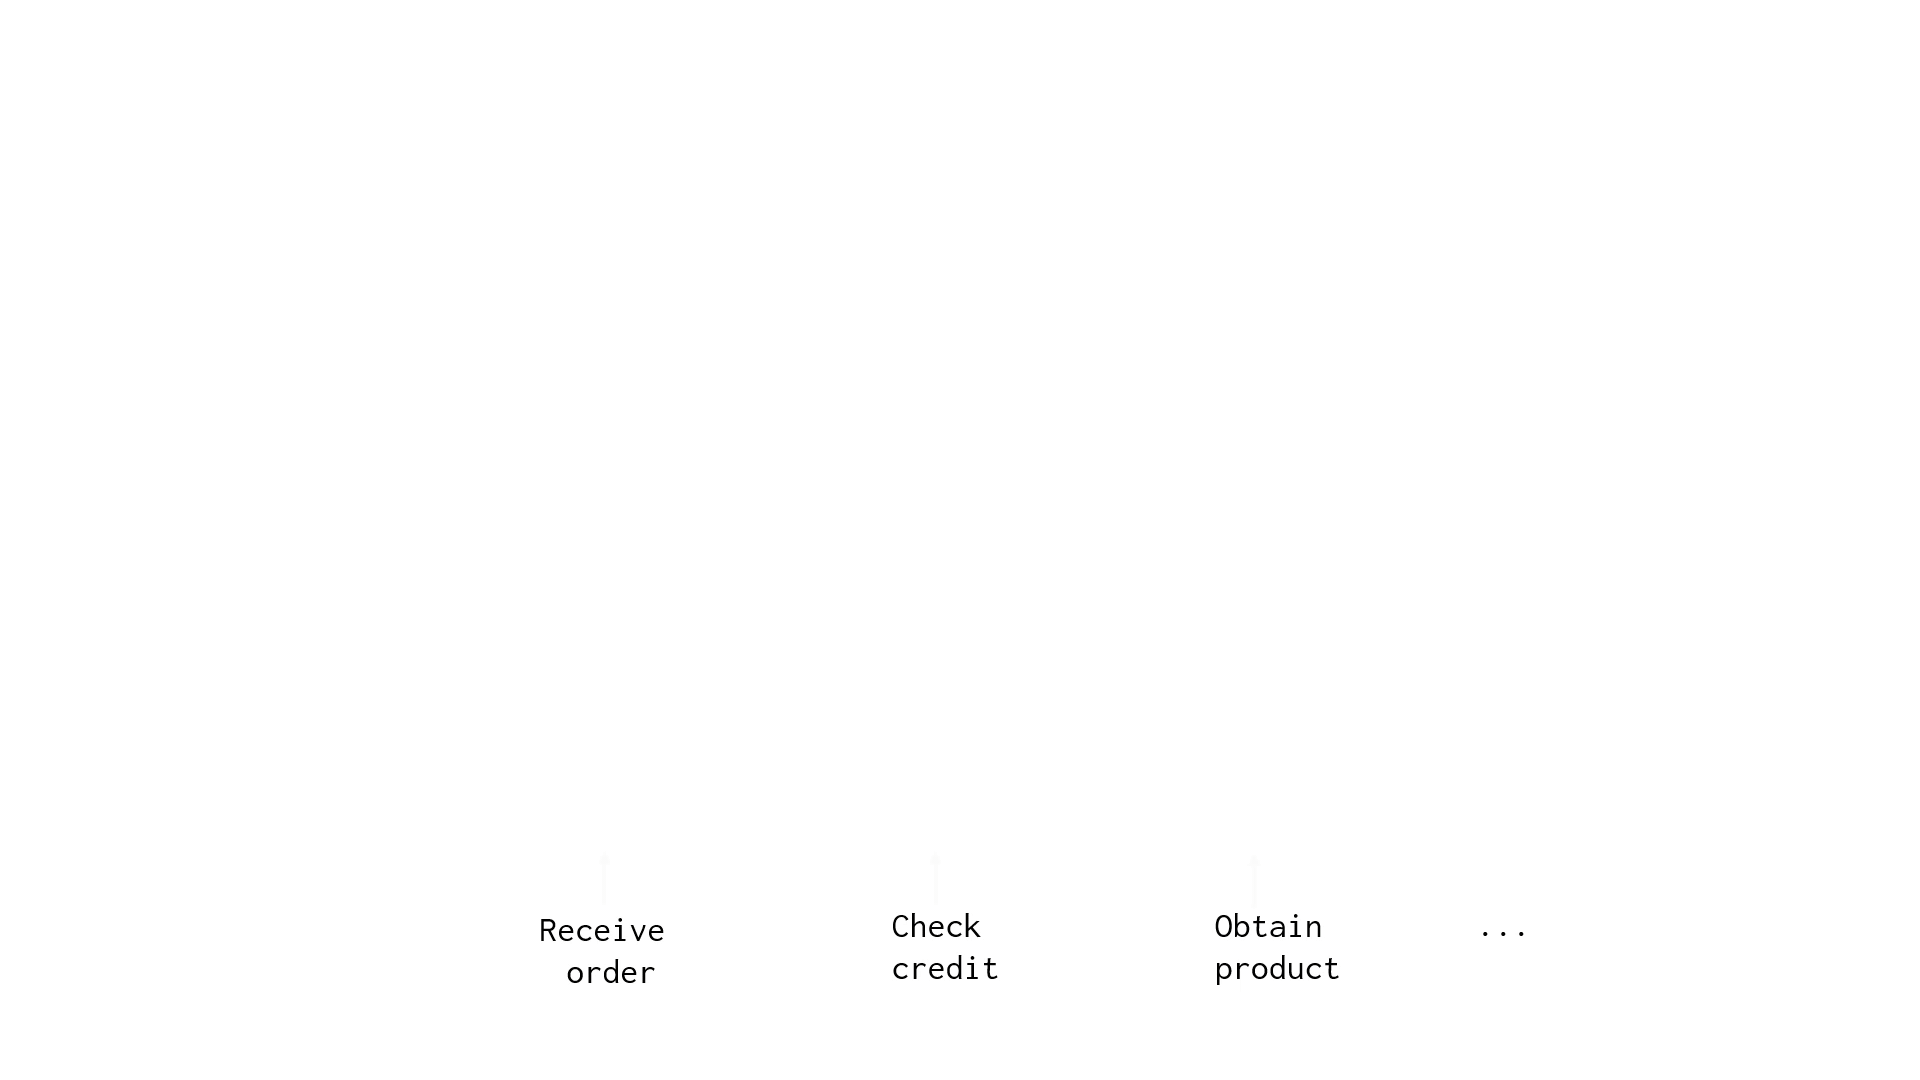


For further details read our paper at https://arxiv.org/abs/2104.00721. Cite us as:


```
@misc{bukhsh2021processtransformer,
      title={ProcessTransformer: Predictive Business Process Monitoring with Transformer Network}, 
      author={Zaharah A. Bukhsh and Aaqib Saeed and Remco M. Dijkman},
      year={2021},
      eprint={2104.00721},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}
```



### Install Packages

In [1]:
!pip install wget
!pip install processtransformer==0.1.3 

^C


### Imports

In [1]:
import os
import wget
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics 

from processtransformer import constants
from processtransformer.models import transformer
from processtransformer.data.loader import LogsDataLoader
from processtransformer.data.processor import LogsDataProcessor

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Next Activity Prediction
We will be using `Helpdesk` event logs as an example. 
**Do not forget to change the runtime type to GPU for efficient execution**.

#### Data processing

In [3]:
data_dir = "./datasets/"
if not os.path.exists(data_dir): 
  os.mkdir(data_dir)
_ = wget.download("https://data.4tu.nl/ndownloader/files/23993303")

-1 / unknown

In [3]:
data_processor = LogsDataProcessor(name='helpdesk', filepath="./datasets/helpdesk/helpdesk.csv",
                                    columns = ["Case ID", "Activity", "Complete Timestamp"], #specify the columns name containing case_id, activity name and timestamp 
                                    dir_path='datasets', pool = 4)
data_processor.process_logs(task=constants.Task.NEXT_ACTIVITY, sort_temporally= False)

In [6]:
# Load data
data_loader = LogsDataLoader(name = 'helpdesk')

(train_df, test_df, x_word_dict, y_word_dict, max_case_length, 
    vocab_size, num_output) = data_loader.load_data(constants.Task.NEXT_ACTIVITY)

# Prepare training examples for next activity prediction task
train_token_x, train_token_y = data_loader.prepare_data_next_activity(train_df, 
    x_word_dict, y_word_dict, max_case_length)

#### Specfiy arguments

In [7]:
learning_rate = 0.001
batch_size = 12
epochs = 10

#### Training the model

In [8]:
# Create and train a transformer model
transformer_model = transformer.get_next_activity_model(
    max_case_length=max_case_length, 
    vocab_size=vocab_size,
    output_dim=num_output)

transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

transformer_model.fit(train_token_x, train_token_y, 
    epochs=epochs, batch_size=batch_size)

Epoch 1/10
1121/1121 [==============================] - 4s 2ms/step - loss: 0.7968 - sparse_categorical_accuracy: 0.7377
Epoch 2/10
1121/1121 [==============================] - 3s 2ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.7906
Epoch 3/10
1121/1121 [==============================] - 3s 2ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.7926
Epoch 4/10
1121/1121 [==============================] - 3s 2ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.7921
Epoch 5/10
1121/1121 [==============================] - 3s 2ms/step - loss: 0.6408 - sparse_categorical_accuracy: 0.7920
Epoch 6/10
1121/1121 [==============================] - 3s 2ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.7922
Epoch 7/10
1121/1121 [==============================] - 3s 2ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.7929
Epoch 8/10
1121/1121 [==============================] - 3s 2ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.7932
Epoch 9/10
1121/1121 [==========

#### Evaluate the model

In [9]:
# Evaluate over all the prefixes (k) and save the results
k, accuracies,fscores, precisions, recalls = [],[],[],[],[]
for i in range(max_case_length):
    test_data_subset = test_df[test_df["k"]==i]
    if len(test_data_subset) > 0:
        test_token_x, test_token_y = data_loader.prepare_data_next_activity(test_data_subset, 
            x_word_dict, y_word_dict, max_case_length)   
        y_pred = np.argmax(transformer_model.predict(test_token_x), axis=1)
        accuracy = metrics.accuracy_score(test_token_y, y_pred)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
            test_token_y, y_pred, average="weighted")
        k.append(i)
        accuracies.append(accuracy)
        fscores.append(fscore)
        precisions.append(precision)
        recalls.append(recall)

k.append(i + 1)
accuracies.append(np.mean(accuracy))
fscores.append(np.mean(fscores))
precisions.append(np.mean(precisions))
recalls.append(np.mean(recalls))

1/1 [==============================] - 0s 14ms/step


In [10]:
print('Average accuracy across all prefixes:', np.mean(accuracies))
print('Average f-score across all prefixes:', np.mean(fscores))
print('Average precision across all prefixes:', np.mean(precisions))
print('Average recall across all prefixes:', np.mean(recalls))

Average accuracy across all prefixes: 0.8456180475601874
Average f-score across all prefixes: 0.7902222341461914
Average precision across all prefixes: 0.7944019684040595
Average recall across all prefixes: 0.8327528848568697


### Event Time Prediction 

#### Data processing

In [ ]:
data_dir = "./datasets/"
if not os.path.exists(data_dir): 
  os.mkdir(data_dir)
_ = wget.download("https://data.4tu.nl/ndownloader/files/23993303")

In [ ]:
data_processor = LogsDataProcessor(name='helpdesk', filepath="finale.csv",  
                                    columns = ["Case ID", "Activity", "Complete Timestamp"],  #specify the columns name containing case_id, activity name and timestamp 
                                    dir_path='datasets', pool = 4)
data_processor.process_logs(task=constants.Task.NEXT_TIME, sort_temporally= False)

In [ ]:
# Load data
data_loader = LogsDataLoader(name = 'helpdesk')

(train_df, test_df, x_word_dict, y_word_dict, max_case_length, 
    vocab_size, num_output) = data_loader.load_data(constants.Task.NEXT_TIME)

# Prepare training examples for next time prediction task
(train_token_x, train_time_x, train_token_y, time_scaler, y_scaler) = \
                                    data_loader.prepare_data_next_time(train_df, x_word_dict, max_case_length)

#### Specfiy arguments

In [ ]:
learning_rate = 0.001
batch_size = 12
epochs = 1

#### Training the model

In [ ]:
# Create and train a transformer model
transformer_model = transformer.get_next_time_model(
        max_case_length=max_case_length, 
        vocab_size=vocab_size)

transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.LogCosh())

transformer_model.fit([train_token_x, train_time_x], train_token_y, 
        epochs=epochs, batch_size=batch_size, verbose=2)

1426/1426 - 10s - loss: 0.1581


#### Evaluate the model

In [ ]:
# Evaluate over all the prefixes (k) and save the results
k, maes, mses, rmses = [],[],[],[]
for i in range(max_case_length):
    test_data_subset = test_df[test_df["k"]==i]
    if len(test_data_subset) > 0:
        test_token_x, test_time_x, test_y, _, _ = data_loader.prepare_data_next_time(
            test_data_subset, x_word_dict, max_case_length, time_scaler, y_scaler, False)   

        y_pred = transformer_model.predict([test_token_x, test_time_x])
        _test_y = y_scaler.inverse_transform(test_y)
        _y_pred = y_scaler.inverse_transform(y_pred)

        k.append(i)
        maes.append(metrics.mean_absolute_error(_test_y, _y_pred))
        mses.append(metrics.mean_squared_error(_test_y, _y_pred))
        rmses.append(np.sqrt(metrics.mean_squared_error(_test_y, _y_pred)))

k.append(i + 1)
maes.append(np.mean(maes))
mses.append(np.mean(mses))
rmses.append(np.mean(rmses))  

In [ ]:
print('Average MAE across all prefixes:', np.mean(maes))
print('Average MSE across all prefixes:', np.mean(mses))
print('Average RMSE across all prefixes:', np.mean(rmses))

Average MAE across all prefixes: 3.2118218
Average MSE across all prefixes: 32.903393
Average RMSE across all prefixes: 5.128949


### Remaining Time Prediction

#### Data processing

In [ ]:
data_dir = "./datasets/"
if not os.path.exists(data_dir): 
  os.mkdir(data_dir)
_ = wget.download("https://data.4tu.nl/ndownloader/files/23993303")

In [ ]:
data_processor = LogsDataProcessor(name='helpdesk', filepath="finale.csv",  
                                    columns = ["Case ID", "Activity", "Complete Timestamp"],  #specify the columns name containing case_id, activity name and timestamp 
                                    dir_path='datasets', pool = 4)
data_processor.process_logs(task=constants.Task.REMAINING_TIME, sort_temporally= False)

In [ ]:
# Load data
data_loader = LogsDataLoader(name = 'helpdesk')

(train_df, test_df, x_word_dict, y_word_dict, max_case_length, 
    vocab_size, num_output) = data_loader.load_data(constants.Task.REMAINING_TIME)

# Prepare training examples for next time prediction task
(train_token_x, train_time_x, 
    train_token_y, time_scaler, y_scaler) = data_loader.prepare_data_remaining_time(train_df, 
    x_word_dict, max_case_length)

#### Specfiy arguments

In [ ]:
learning_rate = 0.001
batch_size = 12
epochs = 1

#### Training the model

In [ ]:
# Create and train a transformer model
transformer_model = transformer.get_remaining_time_model(
    max_case_length=max_case_length, 
    vocab_size=vocab_size)

transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.LogCosh())

transformer_model.fit([train_token_x, train_time_x], train_token_y, 
        epochs=epochs, batch_size=batch_size, verbose=2)

1426/1426 - 9s - loss: 0.0915


#### Evaluate the model

In [ ]:
# Evaluate over all the prefixes (k) and save the results
k, maes, mses, rmses = [],[],[],[]
for i in range(max_case_length):
    test_data_subset = test_df[test_df["k"]==i]
    if len(test_data_subset) > 0:
        test_token_x, test_time_x, test_y, _, _ = data_loader.prepare_data_remaining_time(
            test_data_subset, x_word_dict, max_case_length, time_scaler, y_scaler, False)   

        y_pred = transformer_model.predict([test_token_x, test_time_x])
        _test_y = y_scaler.inverse_transform(test_y)
        _y_pred = y_scaler.inverse_transform(y_pred)

        k.append(i)
        maes.append(metrics.mean_absolute_error(_test_y, _y_pred))
        mses.append(metrics.mean_squared_error(_test_y, _y_pred))
        rmses.append(np.sqrt(metrics.mean_squared_error(_test_y, _y_pred)))

k.append(i + 1)
maes.append(np.mean(maes))
mses.append(np.mean(mses))
rmses.append(np.mean(rmses))  

In [ ]:
print('Average MAE across all prefixes:', np.mean(maes))
print('Average MSE across all prefixes:', np.mean(mses))
print('Average RMSE across all prefixes:', np.mean(rmses))

Average MAE across all prefixes: 3.9136102
Average MSE across all prefixes: 31.96811
Average RMSE across all prefixes: 5.2306476
